# Plot of the Week: Representation Geometry Over Training

**Goal:** Visualize how a model’s *learned representation* becomes more structured over training.

We’ll use a **toy neuroscience-inspired dataset**: a monkey making reaches to multiple directions.
Each trial has a reach direction label (e.g., 8 directions). We simulate a population of neurons with cosine-tuning to direction, then train an **autoencoder** to learn a **2D latent representation**.

As training progresses, the 2D latents should become *more organized* (e.g., directions forming a ring / separable clusters).

> If you want a real dataset: the **Neural Latents Benchmark (NLB)** includes the **MC_Maze** center-out reach dataset on DANDI, but it’s heavier to download and isn’t required for this tutorial.  
> See NLB datasets: https://neurallatents.github.io/datasets.html  (optional background)

---

## What question does this plot answer?
How does the geometry of a learned low-dimensional representation evolve over training?

## Why is it important?
Representation learning is often judged by *structure*: do different conditions (here: reach directions) become separable or organized in latent space? This plot shows that structure can **emerge gradually** during optimization.


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score

# Reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

## 1) Simulate a center-out reaching dataset (neural population tuning)

We simulate:
- `K` reach directions (labels 0..K-1)
- `N` neurons (high-dimensional activity)
- a *true* underlying 2D “behavioral latent” that lies on a circle (direction angle)
- neuron firing rates are a nonlinear function of direction + noise

The autoencoder **does not see the label**; it only sees neural activity.


In [33]:
def simulate_reach_dataset(
    n_trials=2000,
    n_neurons=80,
    n_dirs=8,
    noise_std=0.25,
    rate_scale=8.0,
    baseline=2.0,
):
    """Return X (n_trials, n_neurons), y (n_trials,), and true 2D latent z_true (n_trials, 2)."""
    # Direction labels
    y = np.random.randint(0, n_dirs, size=n_trials)

    # True 2D latent on a unit circle
    angles = 2 * np.pi * y / n_dirs
    z_true = np.stack([np.cos(angles), np.sin(angles)], axis=1)  # (T, 2)

    # Random neuron preferred directions & gains (cosine tuning)
    pref = np.random.uniform(0, 2*np.pi, size=n_neurons)
    gain = np.random.uniform(0.5, 1.5, size=n_neurons)

    # Cosine tuning -> firing rates (positive)
    # rate = baseline + rate_scale * gain * (1 + cos(theta - pref))/2
    theta = angles[:, None]  # (T,1)
    rates = baseline + rate_scale * gain[None, :] * (1 + np.cos(theta - pref[None, :])) / 2.0

    # Add Gaussian noise and clip
    rates = rates + np.random.normal(scale=noise_std, size=rates.shape)
    rates = np.clip(rates, 0.0, None)

    # (Optional) Poisson sampling to mimic spike counts, then convert back to "rates"
    # counts = np.random.poisson(rates).astype(np.float32)
    # X = counts

    X = rates.astype(np.float32)
    return X, y.astype(np.int64), z_true.astype(np.float32)

# ---- Main dataset parameters (STUDENTS CAN CHANGE LATER) ----
n_trials = 3000
n_neurons = 80
n_dirs = 8

X_np, y_np, z_true_np = simulate_reach_dataset(
    n_trials=n_trials,
    n_neurons=n_neurons,
    n_dirs=n_dirs,
    noise_std=1.2,
    rate_scale=8.0,
    baseline=2.0,
)

X = torch.tensor(X_np).to(device)
y = torch.tensor(y_np).to(device)

X.shape, y.shape


(torch.Size([3000, 80]), torch.Size([3000]))

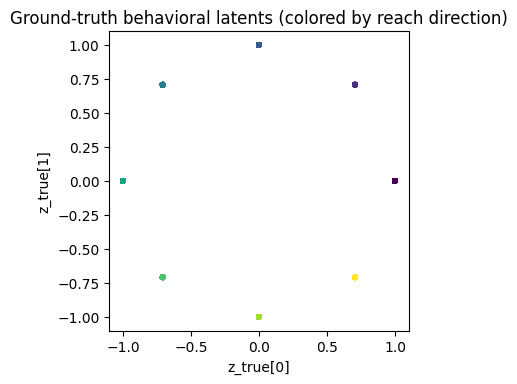

In [34]:
plt.figure(figsize=(4,4))
sc = plt.scatter(
    z_true_np[:,0],
    z_true_np[:,1],
    c=y_np,
    s=10,
    alpha=0.7
)
plt.gca().set_aspect("equal")
plt.xlabel("z_true[0]")
plt.ylabel("z_true[1]")
plt.title("Ground-truth behavioral latents (colored by reach direction)")
plt.tight_layout()
plt.show()

## 2) Autoencoder (2D bottleneck)

We train an MLP autoencoder to reconstruct neural activity `X`.
The encoder output is a **2D latent** that we can visualize directly.


In [35]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=2, hidden_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decoder(z)
        return x_hat, z

latent_dim = 2
hidden_dim = 128

model = AutoEncoder(input_dim=n_neurons, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()


## 3) Train + snapshot latent space over training

We record the 2D latent coordinates at several checkpoints.  
Then we plot *how the latent geometry changes* with training.


In [36]:
def get_latents(model, X, batch_size=512):
    model.eval()
    zs = []
    with torch.no_grad():
        for i in range(0, X.shape[0], batch_size):
            x = X[i:i+batch_size]
            _, z = model(x)
            zs.append(z.detach().cpu().numpy())
    return np.concatenate(zs, axis=0)

def train_and_snapshot(
    model,
    X,
    y,
    epochs=400,
    batch_size=256,
    checkpoints=(0, 10, 50, 200, 400),
):
    loss_hist = []
    snapshots = {}
    sil_hist = []

    # Pre-snapshot at epoch 0
    if 0 in checkpoints:
        z0 = get_latents(model, X)
        snapshots[0] = z0

    model.train()
    for epoch in range(1, epochs + 1):
        idx = torch.randint(0, X.shape[0], (batch_size,), device=X.device)
        xb = X[idx]

        optimizer.zero_grad()
        x_hat, _ = model(xb)
        loss = loss_fn(x_hat, xb)
        loss.backward()
        optimizer.step()

        loss_hist.append(float(loss.item()))

        if epoch in checkpoints:
            z = get_latents(model, X)
            snapshots[epoch] = z

            # Evaluate separability (uses labels only for scoring)
            y_cpu = y.detach().cpu().numpy()
            sil = silhouette_score(z, y_cpu) if len(np.unique(y_cpu)) > 1 else np.nan
            sil_hist.append((epoch, sil))

    return loss_hist, snapshots, sil_hist

epochs = 100
checkpoints = (0, 10, 50, 200, 400)

loss_hist, snapshots, sil_hist = train_and_snapshot(
    model=model,
    X=X,
    y=y,
    epochs=epochs,
    batch_size=256,
    checkpoints=checkpoints,
)

sil_hist[:3], list(snapshots.keys())[:3], len(loss_hist)


([(10, np.float32(-0.09190414)), (50, np.float32(0.17374219))],
 [0, 10, 50],
 100)

## 4) Plot of the Week: latent space snapshots across training

Each subplot shows the **2D latent** for *all trials*, colored by reach direction.  
You should see the latent geometry become more organized over epochs.


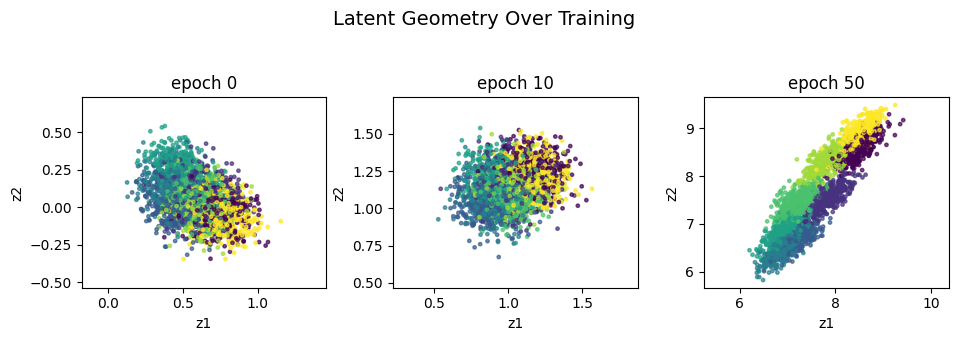

In [37]:
def plot_latent_snapshots(snapshots, y_np, n_dirs, title="Latent Geometry Over Training"):
    epochs = sorted(snapshots.keys())
    n = len(epochs)

    # Layout: up to 5 panels in one row (nice for submission)
    plt.figure(figsize=(3.2*n, 3.2))

    for j, ep in enumerate(epochs):
        z = snapshots[ep]
        plt.subplot(1, n, j+1)
        sc = plt.scatter(z[:, 0], z[:, 1], c=y_np, s=6, alpha=0.7)
        plt.title(f"epoch {ep}")
        plt.xlabel("z1")
        plt.ylabel("z2")
        plt.gca().set_aspect("equal", adjustable="datalim")

    plt.suptitle(title, y=1.05, fontsize=14)
    plt.tight_layout()
    plt.show()

plot_latent_snapshots(snapshots, y_np, n_dirs)


# ==== STUDENT EXPERIMENT SECTION ====

Modify **one** element below and re-run from the top.

Suggested modifications (pick ONE):
1. Change `latent_dim` (try 1, 2, 3) — how does visualization change?
2. Change noise level `noise_std`
3. Change model capacity `hidden_dim`
4. Train longer/shorter (`epochs`, `checkpoints`)

Your submission should include:
- a figure (PNG/PDF) OR notebook output cell
- a 1–2 sentence caption using the template


In [ ]:
# ----- STUDENT: change ONE thing here -----
n_trials = 3000
n_neurons = 80
n_dirs = 8              # try 4 or 16
noise_std = 1.2        # try 0.15 or 0.8
rate_scale = 8.0
baseline = 2.0

latent_dim = 2          # try 1 or 3
hidden_dim = 128        # try 32 or 256
lr = 1e-3               # try 5e-4 or 2e-3

epochs = 400            # try 100 or 800
checkpoints = (0, 10, 50, 200, epochs)

# Re-simulate data
X_np, y_np, z_true_np = simulate_reach_dataset(
    n_trials=n_trials,
    n_neurons=n_neurons,
    n_dirs=n_dirs,
    noise_std=noise_std,
    rate_scale=rate_scale,
    baseline=baseline,
)
X = torch.tensor(X_np).to(device)
y = torch.tensor(y_np).to(device)

# Rebuild model
model = AutoEncoder(input_dim=n_neurons, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train + snapshot
loss_hist, snapshots, sil_hist = train_and_snapshot(
    model=model,
    X=X,
    y=y,
    epochs=epochs,
    batch_size=256,
    checkpoints=checkpoints,
)

# Plot
plot_latent_snapshots(
    snapshots,
    y_np,
    n_dirs,
    title=f"Latent Geometry Over Training (K={n_dirs}, noise={noise_std}, hidden={hidden_dim}, latent={latent_dim})"
)
